In [71]:
import pandas as pd
import numpy as np

# 1. Preprocessed Data for Classification

In [72]:
asylum_seekers_processed = pd.read_csv('EDA/processed_asylum_seekers.csv')

In [73]:
asylum_seekers_processed.head()

,year,country_of_residence,country_of_origin,total_applied_during_year,decisions_recognized,total_rejected,decisions_closed,total_pending_year_start,total_pending_year_end,application_authority,stage_of_application,Rejected(Y/N)
0,2000,Zimbabwe,Afghanistan,5.0,5.0,0.0,0.0,0.0,0.0,G,FI,N
1,2000,South Africa,Afghanistan,0.0,0.0,0.0,0.0,9.0,8.0,G,FI,N
2,2000,Uzbekistan,Afghanistan,2156.0,747.0,112.0,327.0,530.0,2470.0,U,FI,Y
3,2000,USA,Afghanistan,225.0,151.0,31.0,68.0,196.0,171.0,G,EO,Y
4,2000,USA,Afghanistan,218.0,182.0,51.0,40.0,193.0,150.0,G,IN,Y


### 1 = Y (Rejected)
### 0 = N (Not Rejected)

In [74]:
def change_int(x):
    if x=='Y':
        return 1
    else:
        return 0    
asylum_seekers_processed['Rejected(Y/N)'] = asylum_seekers_processed['Rejected(Y/N)'].apply(change_int)

### Drop columns that are very closely aligned to class labels

In [75]:
asylum_seekers_processed = asylum_seekers_processed.drop(['total_rejected', 'decisions_recognized', 'decisions_closed'], axis = 1)

In [76]:
asylum_seekers_processed.head()

,year,country_of_residence,country_of_origin,total_applied_during_year,total_pending_year_start,total_pending_year_end,application_authority,stage_of_application,Rejected(Y/N)
0,2000,Zimbabwe,Afghanistan,5.0,0.0,0.0,G,FI,0
1,2000,South Africa,Afghanistan,0.0,9.0,8.0,G,FI,0
2,2000,Uzbekistan,Afghanistan,2156.0,530.0,2470.0,U,FI,1
3,2000,USA,Afghanistan,225.0,196.0,171.0,G,EO,1
4,2000,USA,Afghanistan,218.0,193.0,150.0,G,IN,1


### Drop class label for X
### y = class label

In [77]:
X_catboost = asylum_seekers_processed.drop('Rejected(Y/N)', axis = 1)
y_catboost = asylum_seekers_processed['Rejected(Y/N)']

In [78]:
X_catboost.head()

,year,country_of_residence,country_of_origin,total_applied_during_year,total_pending_year_start,total_pending_year_end,application_authority,stage_of_application
0,2000,Zimbabwe,Afghanistan,5.0,0.0,0.0,G,FI
1,2000,South Africa,Afghanistan,0.0,9.0,8.0,G,FI
2,2000,Uzbekistan,Afghanistan,2156.0,530.0,2470.0,U,FI
3,2000,USA,Afghanistan,225.0,196.0,171.0,G,EO
4,2000,USA,Afghanistan,218.0,193.0,150.0,G,IN


# First Classification Algorithm is Catboost Classifier

### All non-float features are converted to strings and will be treated as categorical:

In [79]:
import numpy as np

supposed_categorical_features_indices = np.where(X_catboost.dtypes != np.float)[0]
len(supposed_categorical_features_indices)

C:\Users\Sajiah Naqib\AppData\Local\Temp\ipykernel_12336\2204438396.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  supposed_categorical_features_indices = np.where(X_catboost.dtypes != np.float)[0]


5

In [80]:
categorical_features_indices = []
for c in supposed_categorical_features_indices:
    try:
        X_catboost[X_catboost.columns[c]] = X_catboost[X_catboost.columns[c]].astype(float)
        print(X_catboost[X_catboost.columns[c]])
    except:
        categorical_features_indices.append(c)
len(categorical_features_indices)

0         2000.0
1         2000.0
2         2000.0
3         2000.0
4         2000.0
           ...  
129715    2016.0
129716    2016.0
129717    2016.0
129718    2016.0
129719    2016.0
Name: year, Length: 129720, dtype: float64


4

In [81]:
for c in categorical_features_indices:
    X_catboost[X_catboost.columns[c]] = X_catboost[X_catboost.columns[c]].astype(str)
   

### Split dataset into training and testing (33% test dataset)

In [82]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_catboost, y_catboost, test_size=0.33, random_state=42)

In [83]:
classes = np.unique(y_train)

In [84]:
from catboost import CatBoostClassifier
model= CatBoostClassifier(iterations=500,
                                   task_type="CPU",
                                   devices='0:1', cat_features=categorical_features_indices)
model.fit(X_train,y_train,verbose=True)

Learning rate set to 0.130908
0:	learn: 0.6284578	total: 70.9ms	remaining: 35.4s
1:	learn: 0.5813650	total: 135ms	remaining: 33.6s
2:	learn: 0.5460048	total: 204ms	remaining: 33.9s
3:	learn: 0.5224447	total: 271ms	remaining: 33.6s
4:	learn: 0.5006019	total: 348ms	remaining: 34.4s
5:	learn: 0.4858011	total: 417ms	remaining: 34.3s
6:	learn: 0.4741825	total: 473ms	remaining: 33.3s
7:	learn: 0.4645219	total: 535ms	remaining: 32.9s
8:	learn: 0.4552653	total: 607ms	remaining: 33.1s
9:	learn: 0.4488968	total: 667ms	remaining: 32.7s
10:	learn: 0.4415769	total: 801ms	remaining: 35.6s
11:	learn: 0.4370659	total: 869ms	remaining: 35.3s
12:	learn: 0.4302259	total: 940ms	remaining: 35.2s
13:	learn: 0.4263441	total: 1.03s	remaining: 35.9s
14:	learn: 0.4217228	total: 1.1s	remaining: 35.6s
15:	learn: 0.4184069	total: 1.17s	remaining: 35.5s
16:	learn: 0.4160929	total: 1.23s	remaining: 35s
17:	learn: 0.4139753	total: 1.29s	remaining: 34.5s
18:	learn: 0.4119177	total: 1.34s	remaining: 34.1s
19:	learn: 0.

161:	learn: 0.3361648	total: 11.7s	remaining: 24.5s
162:	learn: 0.3358914	total: 11.8s	remaining: 24.5s
163:	learn: 0.3356163	total: 11.9s	remaining: 24.4s
164:	learn: 0.3354185	total: 12s	remaining: 24.3s
165:	learn: 0.3352301	total: 12s	remaining: 24.2s
166:	learn: 0.3351572	total: 12.1s	remaining: 24.2s
167:	learn: 0.3351550	total: 12.2s	remaining: 24.1s
168:	learn: 0.3349595	total: 12.3s	remaining: 24.1s
169:	learn: 0.3347873	total: 12.4s	remaining: 24s
170:	learn: 0.3344671	total: 12.4s	remaining: 23.9s
171:	learn: 0.3343586	total: 12.5s	remaining: 23.9s
172:	learn: 0.3342886	total: 12.6s	remaining: 23.9s
173:	learn: 0.3339907	total: 12.7s	remaining: 23.8s
174:	learn: 0.3339287	total: 12.8s	remaining: 23.8s
175:	learn: 0.3336981	total: 12.9s	remaining: 23.7s
176:	learn: 0.3335384	total: 12.9s	remaining: 23.6s
177:	learn: 0.3334947	total: 13s	remaining: 23.6s
178:	learn: 0.3334071	total: 13.1s	remaining: 23.5s
179:	learn: 0.3331547	total: 13.2s	remaining: 23.5s
180:	learn: 0.332830

321:	learn: 0.3175158	total: 24.7s	remaining: 13.7s
322:	learn: 0.3174274	total: 24.8s	remaining: 13.6s
323:	learn: 0.3173481	total: 24.9s	remaining: 13.5s
324:	learn: 0.3172868	total: 24.9s	remaining: 13.4s
325:	learn: 0.3170901	total: 25s	remaining: 13.3s
326:	learn: 0.3170300	total: 25.1s	remaining: 13.3s
327:	learn: 0.3169702	total: 25.1s	remaining: 13.2s
328:	learn: 0.3168851	total: 25.2s	remaining: 13.1s
329:	learn: 0.3166838	total: 25.3s	remaining: 13s
330:	learn: 0.3165109	total: 25.3s	remaining: 12.9s
331:	learn: 0.3164517	total: 25.4s	remaining: 12.8s
332:	learn: 0.3159981	total: 25.5s	remaining: 12.8s
333:	learn: 0.3158876	total: 25.5s	remaining: 12.7s
334:	learn: 0.3157531	total: 25.6s	remaining: 12.6s
335:	learn: 0.3157047	total: 25.6s	remaining: 12.5s
336:	learn: 0.3156232	total: 25.7s	remaining: 12.4s
337:	learn: 0.3155034	total: 25.8s	remaining: 12.3s
338:	learn: 0.3154213	total: 25.8s	remaining: 12.3s
339:	learn: 0.3153024	total: 25.9s	remaining: 12.2s
340:	learn: 0.31

483:	learn: 0.3042968	total: 36.8s	remaining: 1.22s
484:	learn: 0.3042809	total: 36.8s	remaining: 1.14s
485:	learn: 0.3040164	total: 36.9s	remaining: 1.06s
486:	learn: 0.3038207	total: 37s	remaining: 988ms
487:	learn: 0.3037433	total: 37.1s	remaining: 912ms
488:	learn: 0.3036468	total: 37.2s	remaining: 836ms
489:	learn: 0.3036405	total: 37.3s	remaining: 760ms
490:	learn: 0.3035974	total: 37.3s	remaining: 684ms
491:	learn: 0.3035054	total: 37.4s	remaining: 608ms
492:	learn: 0.3034970	total: 37.4s	remaining: 532ms
493:	learn: 0.3033780	total: 37.5s	remaining: 456ms
494:	learn: 0.3032980	total: 37.6s	remaining: 380ms
495:	learn: 0.3032691	total: 37.7s	remaining: 304ms
496:	learn: 0.3032456	total: 37.8s	remaining: 228ms
497:	learn: 0.3031415	total: 37.8s	remaining: 152ms
498:	learn: 0.3030646	total: 37.9s	remaining: 76ms
499:	learn: 0.3030399	total: 38s	remaining: 0us


In [85]:
prediction = model.predict(X_test)

In [86]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix, recall_score, precision_score, accuracy_score 

In [87]:
print(classification_report(y_test, prediction, digits=3))

              precision    recall  f1-score   support

           0      0.843     0.825     0.834     19791
           1      0.852     0.868     0.860     23017

    accuracy                          0.848     42808
   macro avg      0.848     0.846     0.847     42808
weighted avg      0.848     0.848     0.848     42808



In [88]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

C:\Users\Sajiah Naqib\anaconda3\envs\adm\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


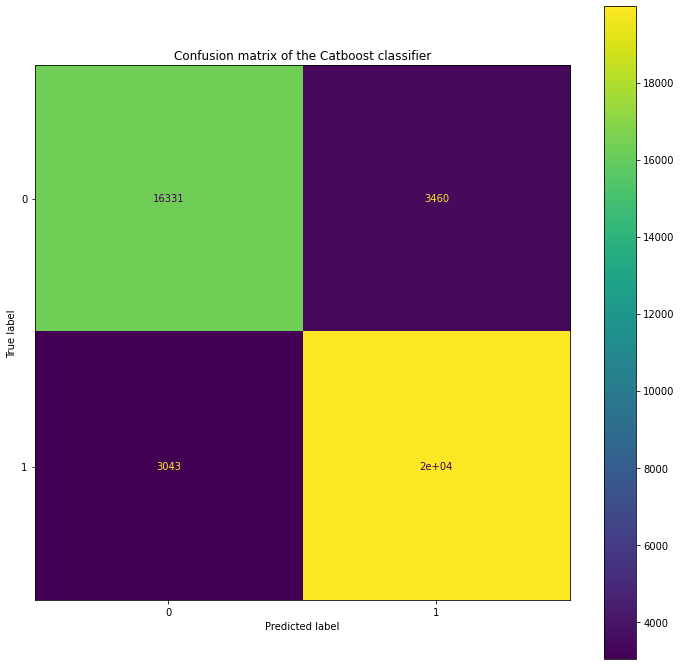

In [89]:
fig, ax = plt.subplots(figsize=(12, 12))
plot_confusion_matrix(model, X_test, y_test, ax=ax)
plt.title('Confusion matrix of the Catboost classifier')
plt.show()

# Second Classification Algorithm is Linear Support Vector Classification

In [90]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [91]:
X_svm_lr = pd.get_dummies(asylum_seekers_processed.drop('Rejected(Y/N)', axis = 1))
y_svm_lr = asylum_seekers_processed['Rejected(Y/N)']

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X_svm_lr, y_svm_lr, test_size=0.33, random_state=42)

In [93]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [94]:
clf = LinearSVC(dual = False, max_iter = 10000)
clf.fit(X_train, y_train)

LinearSVC(dual=False, max_iter=10000)

In [95]:
predicted_y = clf.predict(X_test)

In [96]:
print(classification_report(y_test, predicted_y, digits=3))

              precision    recall  f1-score   support

           0      0.714     0.665     0.688     19791
           1      0.728     0.771     0.749     23017

    accuracy                          0.722     42808
   macro avg      0.721     0.718     0.719     42808
weighted avg      0.721     0.722     0.721     42808



C:\Users\Sajiah Naqib\anaconda3\envs\adm\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


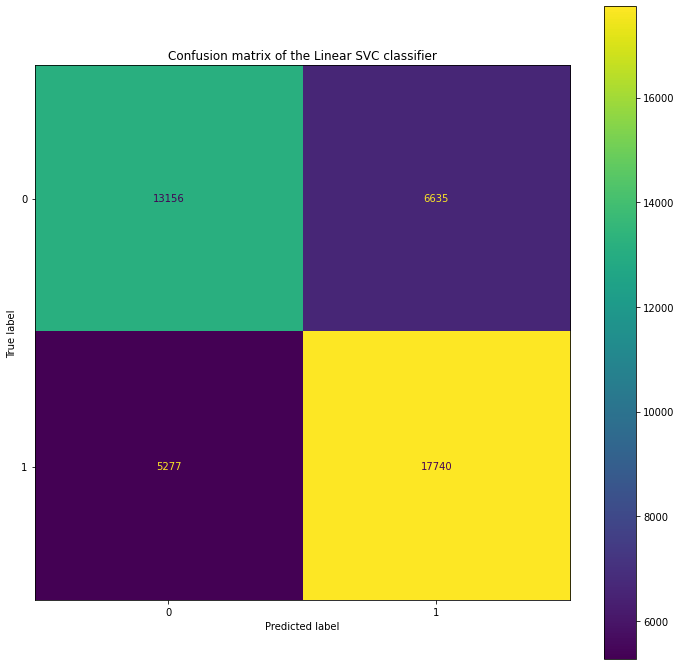

In [97]:
fig, ax = plt.subplots(figsize=(12, 12))
plot_confusion_matrix(clf, X_test, y_test, ax=ax)
plt.title('Confusion matrix of the Linear SVC classifier')
plt.show()

# Third Classification Algorithm is Logistic Regression

In [98]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X_svm_lr, y_svm_lr, test_size=0.33, random_state=42)

In [100]:
lr_model.fit(X_train,
              y_train)
predictions_lr = lr_model.predict(X_test)

C:\Users\Sajiah Naqib\anaconda3\envs\adm\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [101]:
print(classification_report(y_test, predictions_lr, digits=3))

              precision    recall  f1-score   support

           0      0.645     0.490     0.557     19791
           1      0.637     0.768     0.696     23017

    accuracy                          0.640     42808
   macro avg      0.641     0.629     0.627     42808
weighted avg      0.640     0.640     0.632     42808



C:\Users\Sajiah Naqib\anaconda3\envs\adm\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


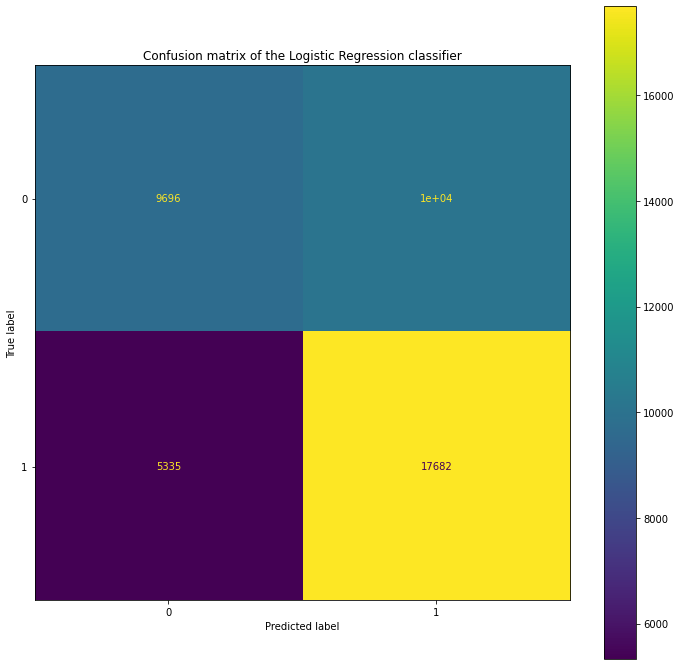

In [102]:
fig, ax = plt.subplots(figsize=(12, 12))
plot_confusion_matrix(lr_model, X_test, y_test, ax=ax)
plt.title('Confusion matrix of the Logistic Regression classifier')
plt.show()

# Fourth Classification Algorithm is Random Forest Classifier

In [103]:
from sklearn.ensemble import RandomForestClassifier
model_rfc = RandomForestClassifier(n_estimators = 500)

In [104]:
model_rfc.fit(X_train, y_train)
predictions_rfc = model_rfc.predict(X_test)

In [105]:
print(classification_report(y_test, predictions_rfc, digits=3))

              precision    recall  f1-score   support

           0      0.837     0.829     0.833     19791
           1      0.854     0.862     0.858     23017

    accuracy                          0.847     42808
   macro avg      0.846     0.845     0.846     42808
weighted avg      0.847     0.847     0.847     42808



C:\Users\Sajiah Naqib\anaconda3\envs\adm\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


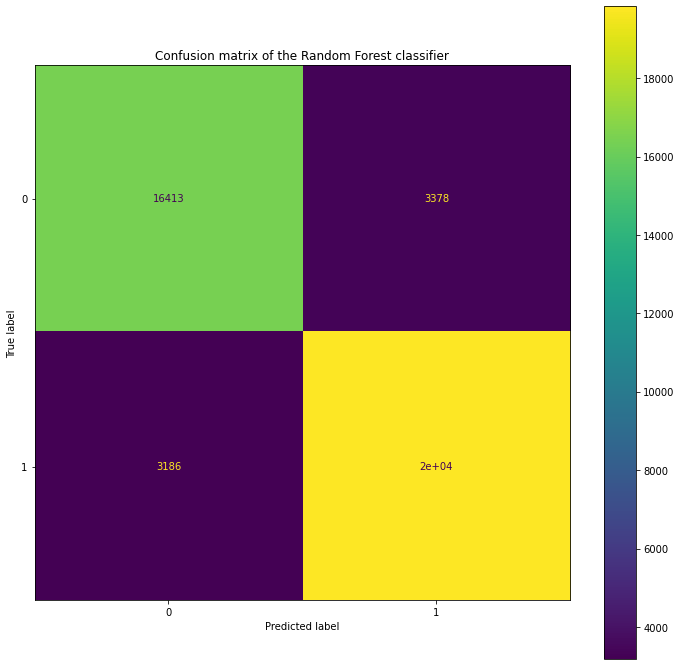

In [106]:
fig, ax = plt.subplots(figsize=(12, 12))
plot_confusion_matrix(model_rfc, X_test, y_test, ax=ax)
plt.title('Confusion matrix of the Random Forest classifier')
plt.show()